<img src="../../images/qiskit-heading.gif" alt="Note: In order for images to show up in this jupyter notebook you need to select File => Trusted Notebook" width="500 px" align="left">

## _*Comparing Classical and Quantum Finite Automata (QFA)*_

Finite Automaton has been a mathematical model for computation since its invention in the 1940s. The purpose of a Finite State Machine is to recognize patterns within an input taken from some character set and accept or reject the input based on whether the pattern defined by the machine occurs in the input. The machine requires a list of states, the initial state, and the conditions for each transition from state to state. Such classical examples are vending machines, coin-operated turnstiles, elevators, traffic lights, etc. 

In the classical algorithm, the sequence begins in the start state, and will only make a transition if the next character in the input string matches the label on the transition from the current to the next state. The machine will continue making transitions on each input character until no move is possible. The string will be accepted if its final state is in the accept state and will be rejected if its final state is anywhere else. 

As for Quantum Finite Automata (QFA), the machine works by accepting a finite-length string of letters from a finite alphabet and utilizing quantum properties such as superposition to assign the string a probability of being in either the accept or reject state. 

***
### Contributors
Kaitlin Gili, Rudy Raymond

## Prime Divisibility Algorithm 

Let's say that we have a string with $ a^i $ letters and we want to know whether the string is in the language $ L $ where $ L $ = {$ a^i $ | $ i $ is divisble by $ p $} and $ p $ is a prime number. If $ i $ is divisible by $ p $, we want to accept the string into the language, and if not, we want to reject it. 
$|0\rangle $ and $ |1\rangle $ serve as our accept and reject states. 

Classically, this algorithm requires a minimum of $ log(p) $ bits to store the information, whereas the quantum algorithm only requires $ log(log(p)) $ qubits. For example, using the highest known prime integer, the classical algorithm requires **a minimum of 77,232,917 bits**, whereas the quantum algorithm **only requires 27 qubits**. 

## Introduction <a id='introduction'></a>

The algorithm in this notebook follows that in [Ambainis et al. 1998](https://arxiv.org/pdf/quant-ph/9802062.pdf). We assume that we are given a string and a prime integer. If the user does not input a prime number, the output will be a ValueError. First, we demonstrate a simpler version of the quantum algorithm that uses $ log(p) $ qubits to store the information. Then, we can use this to more easily understand the quantum algorithm that requires only $ log(log(p)) $ qubits.

## The Algorithm for Log(p) Qubits

The algorithm is quite simple as follows.
1. Prepare quantum and classical registers for $ log(p) $ qubits initialized to zero. 
$$ |0\ldots 0\rangle $$ 
2. Prepare $ log(p) $ random numbers k in the range {$ 1 $... $ p-1 $}. These numbers will be used to decrease the probability of a string getting accepted when $ i $ does not divide $ p $. 
3. Perform a number of $ i $ Y-Rotations on each qubit, where $ \theta $ is initially zero and $ \Phi $ is the angle of rotation for each unitary. $$ \Phi = \frac{2 \pi k}{p} $$
4. In the final state: 
$$ \cos \theta |0\rangle + \sin \theta |1\rangle $$
$$ \theta = \frac{2 \pi k} p {i} $$
5. Measure each of the qubits in the classical register. If $ i $ divides $ p $, $ \cos \theta $ will be one for every qubit and the state will collapse to $ |0\rangle $ to demonstrate an accept state with a probability of one. Otherwise, the output will consist of a small probability of accepting the string into the language and a higher probability of rejecting the string.

## The Circuit <a id="circuit"></a>

We now implement the QFA Prime Divisibility algorithm with QISKit by first preparing the environment.

In [8]:
# useful additional packages 
import random
import time
import math
from sympy.ntheory import isprime

# importing the QISKit
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit import IBMQ, Aer, execute, register

In [2]:
#import Qconfig and set APIToken and API url
try:
    import sys
    sys.path.append("../../") # go to parent dir
    import Qconfig
    qx_config = {
        "APItoken": Qconfig.APItoken,
        "url": Qconfig.config['url']}
except Exception as e:
    print(e)
IBMQ.enable_account(qx_config['APItoken'], qx_config['url'])
"Available backends:", IBMQ.available_backends()

('Available backends:',
 [<IBMQBackend('ibmqx4') from IBMQ()>,
  <IBMQBackend('ibmqx5') from IBMQ()>,
  <IBMQBackend('ibmqx2') from IBMQ()>,
  <IBMQBackend('ibmq_16_melbourne') from IBMQ()>,
  <IBMQBackend('ibmq_qasm_simulator') from IBMQ()>])

We then use QISKit to program the algorithm.

In [3]:
#Function that takes in a prime number and a string of letters and returns a quantum circuit
def qfa_algorithm(string, prime):
    if isprime(prime) == False:
        raise ValueError("This number is not a prime") #Raises a ValueError if the input prime number is not prime
    else:
        n = math.ceil((math.log(prime))) #Rounds up to the next integer of the log(prime)
        qr = QuantumRegister(n) #Creates a quantum register of length log(prime) for log(prime) qubits
        cr = ClassicalRegister(n) #Creates a classical register for measurement 
        circuitName = "QuantumFiniteAutomata" #Name of the circuit/algorithm 
        qfaCircuit = QuantumCircuit(qr, cr) #Defining the circuit to take in the values of qr and cr
        for x in range(n): #For each qubit, we want to apply a series of unitary operations with a random int
            random_value = random.randint(1,prime - 1) #Generates the random int for each qubit from {1, prime -1}
            for letter in string: #For each letter in the string, we want to apply the same unitary operation to each qubit
                qfaCircuit.ry((2*math.pi*random_value) / prime, qr[x]) #Applies the Y-Rotation to each qubit 
            qfaCircuit.measure(qr[x], cr[x]) #Measures each qubit 
        return qfaCircuit #Returns the created quantum circuit


The qfa_algorithm function returns the Quantum Circuit qfaCircuit.

## Experiment with Simulators

We can run the above circuit on the simulator. 

In [4]:
#A function that returns a string saying if the string is accepted into the language or rejected
def accept(parameter):
    states = list(result.get_counts(parameter))
    for s in states:
        for integer in s:
            if integer == "1":
                return "Reject: the string is not accepted into the language"
    return "Accept: the string is accepted into the language"

Insert your own parameters and try even larger prime numbers.

In [6]:
range_lower = 0
range_higher = 36
prime_number = 11

In [7]:
for length in range(range_lower,range_higher):
    params = qfa_algorithm("a"* length, prime_number)
    job = execute(params, Aer.get_backend("qasm_simulator"), shots=1000)
    result = job.result()
    print(accept(params), "\n", "Length:",length," " ,result.get_counts(params))

Accept: the string is accepted into the language 
 Length: 0   {'000': 1000}
Reject: the string is not accepted into the language 
 Length: 1   {'111': 209, '101': 489, '100': 107, '011': 47, '110': 24, '001': 102, '000': 19, '010': 3}
Reject: the string is not accepted into the language 
 Length: 2   {'101': 747, '001': 160, '011': 9, '111': 67, '100': 13, '000': 2, '110': 2}
Reject: the string is not accepted into the language 
 Length: 3   {'100': 471, '000': 382, '101': 45, '110': 26, '010': 40, '001': 29, '111': 3, '011': 4}
Reject: the string is not accepted into the language 
 Length: 4   {'001': 475, '101': 49, '011': 41, '000': 359, '100': 32, '010': 41, '111': 2, '110': 1}
Reject: the string is not accepted into the language 
 Length: 5   {'001': 323, '101': 451, '111': 39, '100': 84, '110': 11, '011': 23, '000': 61, '010': 8}
Reject: the string is not accepted into the language 
 Length: 6   {'100': 87, '111': 38, '101': 418, '001': 352, '000': 65, '011': 27, '110': 11, '010

### Drawing the circuit of the QFA

Below is the snapshop of the QFA for reading the bitstring of length $3$. It can be seen that there are independent QFAs each of which performs $Y$ rotation for $3$ times.  

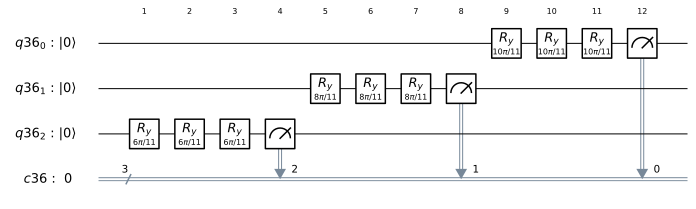

In [9]:
from qiskit.tools.visualization import matplotlib_circuit_drawer as drawer, qx_color_scheme

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

my_style = {
    "usepiformat": True,
    "cregbundle": True,
    "showindex": True,
    "compress": True
}
drawer(qfa_algorithm("a"* 3, prime_number), style=my_style)

## The Algorithm for Log(Log(p)) Qubits

The algorithm is quite simple as follows.
1. Prepare a quantum register for $ log(log(p)) + 1 $ qubits initialized to zero. The $ log(log(p))$ qubits will act as your control bits and the 1 extra will act as your target bit. Also prepare a classical register for 1 bit to measure the target. 
$$ |0\ldots 0\rangle |0\rangle  $$ 
2. Hadamard the control bits to put them in a superposition so that we can perform multiple QFA's at the same time.
3. For each of $s $ states in the superposition, we can perform an individual QFA with the control qubits acting as the random integer $ k $ from the previous algorithm. Thus, we need $ n $ values from $ 1... log(p)$ for $ k $. For each letter $ i $ in the string, we perform a controlled y-rotation on the target qubit, where $ \theta $ is initially zero and $ \Phi $ is the angle of rotation for each unitary. $$ \Phi = \frac{2 \pi k_{s}}{p} $$
4. The target qubit in the final state: 
$$ \cos \theta |0\rangle + \sin \theta |1\rangle $$
$$ \theta = \sum_{s=0}^n \frac{2 \pi k_{s}} p {i} $$
5. Measure the target qubit in the classical register. If $ i $ divides $ p $, $ \cos \theta $ will be one for every QFA and the state of the target will collapse to $ |0\rangle $ to demonstrate an accept state with a probability of one. Otherwise, the output will consist of a small probability of accepting the string into the language and a higher probability of rejecting the string.

## The Circuit <a id="circuit"></a>

We then use QISKit to program the algorithm.

In [10]:
#Function that takes in a prime number and a string of letters and returns a quantum circuit
def qfa_controlled_algorithm(string, prime):
    if isprime(prime) == False:
        raise ValueError("This number is not a prime") #Raises a ValueError if the input prime number is not prime
    else:
        n = math.ceil((math.log(math.log(prime,2),2))) #Represents log(log(p)) control qubits 
        states = 2 ** (n) #Number of states that the qubits can represent/Number of QFA's to be performed 
        qr = QuantumRegister(n+1) #Creates a quantum register of log(log(prime)) control qubits + 1 target qubit
        cr = ClassicalRegister(1) #Creates a classical register of log(log(prime)) control qubits + 1 target qubit
        circuitName = "QuantumFiniteAutomata" #Name of the circuit/algorithm 
        control_qfaCircuit = QuantumCircuit(qr, cr) #Defining the circuit to take in the values of qr and cr
        for q in range(n): #We want to take each control qubit and put them in a superposition by applying a Hadamard Gate
            control_qfaCircuit.h(qr[q])
        for letter in string: #For each letter in the string, we want to apply a series of Controlled Y-rotations
            for q in range(n):  
                control_qfaCircuit.cu3(2*math.pi*(2**q)/prime, 0, 0, qr[q], qr[n]) #Controlled Y on Target qubit 
        control_qfaCircuit.measure(qr[n], cr[0]) #Measure the target qubit  
        return control_qfaCircuit #Returns the created quantum circuit  

The qfa_algorithm function returns the Quantum Circuit control_qfaCircuit.

## Experiment with Simulators

We can run the above circuit on the simulator. 

In [11]:
for length in range(range_lower,range_higher):
    params = qfa_controlled_algorithm("a"* length, prime_number)
    job = execute(params, Aer.get_backend("qasm_simulator"), shots=1000)
    result = job.result()
    print(accept(params), "\n", "Length:",length," " ,result.get_counts(params))

Accept: the string is accepted into the language 
 Length: 0   {'0': 1000}
Reject: the string is not accepted into the language 
 Length: 1   {'0': 733, '1': 267}
Reject: the string is not accepted into the language 
 Length: 2   {'1': 550, '0': 450}
Reject: the string is not accepted into the language 
 Length: 3   {'0': 547, '1': 453}
Reject: the string is not accepted into the language 
 Length: 4   {'1': 340, '0': 660}
Reject: the string is not accepted into the language 
 Length: 5   {'1': 495, '0': 505}
Reject: the string is not accepted into the language 
 Length: 6   {'1': 491, '0': 509}
Reject: the string is not accepted into the language 
 Length: 7   {'0': 637, '1': 363}
Reject: the string is not accepted into the language 
 Length: 8   {'0': 520, '1': 480}
Reject: the string is not accepted into the language 
 Length: 9   {'1': 511, '0': 489}
Reject: the string is not accepted into the language 
 Length: 10   {'0': 775, '1': 225}
Accept: the string is accepted into the lang

### Drawing the circuit of the QFA

Below is the snapshot of the QFA for reading the bitstring of length $3$. It can be seen that there is a superposition of QFAs instead of independent QFAs. 

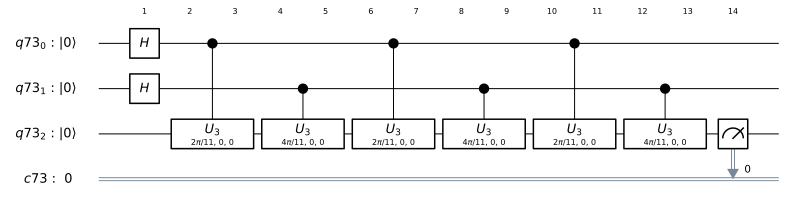

In [12]:
drawer(qfa_controlled_algorithm("a"* 3, prime_number), style=my_style)

## Experimenting with Real Devices

Real-device backends have errors and if the above QFAs are executed on the noisy backends, errors in rejecting strings that should have been accepted can happen. Let us see how well the real-device backends can realize the QFAs. 

We first prepare the environment. 

In [13]:
"Available local backends:", Aer.available_backends()

('Available local backends:',
 [<QasmSimulatorPy('qasm_simulator_py') from Aer()>,
  <StatevectorSimulatorPy('statevector_simulator_py') from Aer()>,
  <UnitarySimulator('unitary_simulator') from Aer()>])

In [14]:
"Available real-device backends:", IBMQ.available_backends()

('Available real-device backends:',
 [<IBMQBackend('ibmqx4') from IBMQ()>,
  <IBMQBackend('ibmqx5') from IBMQ()>,
  <IBMQBackend('ibmqx2') from IBMQ()>,
  <IBMQBackend('ibmq_16_melbourne') from IBMQ()>,
  <IBMQBackend('ibmq_qasm_simulator') from IBMQ()>])

If real-device backends such as `ibmqx4` or `ibmqx5` are available, we should see them with `available_backends()`. Now, let us test the QFAs with some available real-device backends.

Let us look an example when the QFA should reject the bitstring because the length of the bitstring is not divisible by the prime number.

In [19]:
for Backend in IBMQ.backends(operational=True, simulator=False):
    print(Backend.status())

{'pending_jobs': 48, 'name': 'ibmqx4', 'operational': True}
{'pending_jobs': 4, 'name': 'ibmq_16_melbourne', 'operational': True}


The length of a is 2  while the prime number is 3
Status @ 0 seconds
JobStatus.INITIALIZING
Status @ 30 seconds
JobStatus.QUEUED
Status @ 60 seconds
JobStatus.RUNNING
JobStatus.DONE


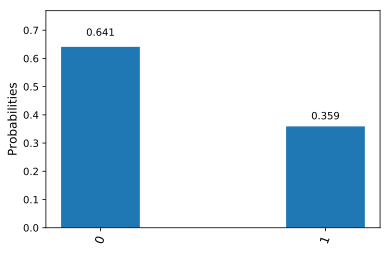

In [15]:
backend = IBMQ.get_backend("ibmq_16_melbourne")
shots = 1000

prime_number = 3
length = 2          # set the length so that it is not divisible by the prime_number
print("The length of a is", length, " while the prime number is", prime_number)
qfa1 = qfa_controlled_algorithm("a"* length, prime_number)

if backend.status()["operational"] is True:   
    job = execute(qfa1, backend=backend, shots=shots)
    lapse = 0
    interval = 30
    while str(job.status()) != 'JobStatus.DONE':
        print('Status @ {} seconds'.format(interval * lapse))
        print(job.status())
        time.sleep(interval)
        lapse += 1
    print(job.status())
    
    result = job.result()
    plot_histogram(result.get_counts())

In the above, we can see that the probability of observing "1" is quite significant. Let us see how the circuit looks like. 

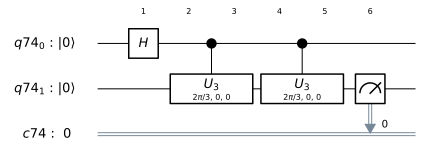

In [16]:
drawer(qfa1, style=my_style)

Now, let us see what happens when the QFAs should accept the input string.

The length of a is 3  while the prime number is 3
Status @ 0 seconds
JobStatus.INITIALIZING
Status @ 30 seconds
JobStatus.RUNNING
JobStatus.DONE


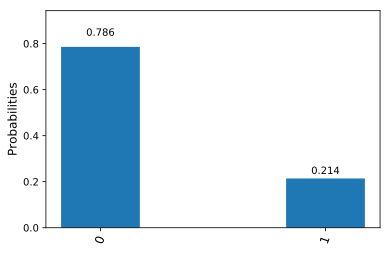

In [17]:
print_number = length = 3 # set the length so that it is divisible by the prime_number
print("The length of a is", length, " while the prime number is", prime_number)
qfa2 = qfa_controlled_algorithm("a"* length, prime_number)

if backend.status()["operational"] is True:  
    job = execute(qfa2, backend=backend, shots=shots)
    lapse = 0
    interval = 30
    while str(job.status()) != 'JobStatus.DONE':
        print('Status @ {} seconds'.format(interval * lapse))
        print(job.status())
        time.sleep(interval)
        lapse += 1
    print(job.status())
    
    result = job.result()
    plot_histogram(result.get_counts())

The error of rejecting the bitstring is equal to the probability of observing "1" which can be checked from the above histogram. We can see that the noise of real-device backends prevents us to have a correct answer. It is left as future work on how to mitigate errors of the backends in the QFA models. 

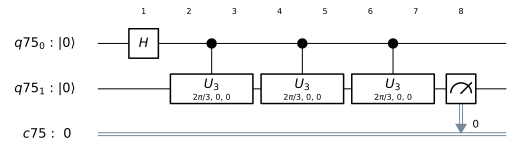

In [18]:
drawer(qfa2, style=my_style)